# Bayesian Hierarchical Clustering
## Prototype Build

The intent of this notebook is to implement a preliminary version of the *Bayesian Hierarchical Clustering* (BHC) algorithm.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import linalg as la
from scipy import random as rnd
import matplotlib.pyplot as plt

### Generate Example Data

Example data will consist of a mixture of three gaussian distributions with varying parameters. It will be clustered via random draws of a multinomial distribution.

In [2]:
# bivariate gaussian params
mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([5, 3])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 12])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params
p1 = 0.4
p2 = 0.3
p3 = 1 - p2 - p1

# number of total draws
draws = 200

In [3]:
# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

In [4]:
# join columns into dataframe
x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "c" : c}
clustData = pd.DataFrame(dat)

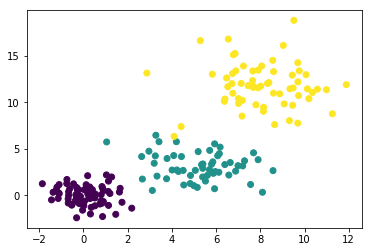

In [5]:
plt.scatter(clustData["x1"], clustData["x2"], c = clustData["c"])
plt.show()

### Preliminary Algorithm

***BHC Steps:***


1. Input
    - Data: $D = \{\vec{x_1}, ..., \vec{x_n}\}$ 
    - Select generative model: $p(\vec{x} | \theta)$
    - Select appropriate prior: $p(\theta | \theta_0)$

2. Initialize Stage
    - Number of initial clusters: `c = len(D)`
    - $D_i = {\vec{x_i}}$ for $i = 1, ..., n$

3. Iterate Stage
    `while c > 1:`
    
    - find data pair $D_i$, $D_j$ w/ highest posterior probability for merge hypothesis: $r_k = p(H^1_k | D_k) = \frac{p(D_k | H^1_k)\pi_k}{p(D_k | T_k)}$
    - merge clusters $D_k = D_i \cup D_j$
    - delete old clusters $D_i$ and $D_j$
    - interate number of clusters `c -= 1`
    
   `end loop`

***Output:***

Bayesian mixture model where each tree node is a mixture component. Tree can be cut at points where $r_k < 0.5$.

### Building Algorithm Components

In [ ]:
# define prior probability for hypothesis 1

def prior_scale(alpha, nk, dleft, dright):
    """calculate scale parameter for merge cluster prior
    alpha - a cluster concentration parameter
    nk - the number of points in new cluster Dk
    dleft - prior scale for left subtree
    dright - prior scale for right subtree"""
    pass

def clust_k_prior(alpha, nk, dk):
    """Prior probability for merging clusters i, j into a single cluster k
    alpha - a cluster concentration parameter
    nk - the number of points in new cluster Dk
    dk - is a scale parameter"""
    pass
    
    

In [6]:
# hyper params

def mvtnorm_post_mean(mu0, ybar, sig0, cov, n):
    """mutlivariate normal posterior mean"""
    mu0 = mu0.reshape(-1, 1)
    ybar = ybar.reshape(-1, 1)
    s = cov.shape[0] # size of covariance matrix
    idty = np.eye(s) # identity for inverting with la.solve
    
    num = la.solve(sig0, idty) @ mu0 + n * la.solve(cov, idty) @ ybar
    denom = la.solve(la.solve(sig0, idty) + n * la.solve(cov, idty), idty)
    
    return denom @ num

def mvtnorm_post_cov(sig0, cov, n):
    """mutlivariate normal posterior covariance"""
    s = cov.shape[0] # size of covariance matrix
    idty = np.eye(s) # identity for inverting with la.solve
    
    res = la.solve(la.solve(sig0, idty) + n * la.solve(cov, idty), idty)
    return res

def generative_likelihood(mu, cov, *xs):
    """likelihood of data under mu and cov (mvtnorm)
    mu - mean vector of distribution
    cov - covariance matrix
    *xs - *args list of vectors in set (cluster)"""
    lik = 1
    # iterative product of likelihoods
    for x in xs:
        lik *= stats.multivariate_normal.pdf(x, mu, cov)
    return lik

In [9]:
# zero matrix for storing posterior merge probs btwn clusters
mergeProbs = np.zeros((clustData.shape[0], clustData.shape[0]))

for n, i in enumerate(clustData.values[:, :2]):
    for m, j in enumerate(clustData.values[:, :2]):
        if n <= m:
            break
        # these parameters are placeholders
        ybar = np.zeros(2) 
        sig = np.eye(2)
        # calculate likelihood of two points being generated from the same distribution
        # this does not currently take a prior distribution into account
        # insert the probability in the zero matrix mergeProbs
        mergeProbs[m, n] = generative_likelihood(ybar, sig, i, j)

**Visualizing the mergeProbs matrix**

The plot below depicts a few important points:
1. "hot spots" indicate where probability of two points being from a single distribution is high
2. cold spots are areas where the prob is low. After a while everything is cold. This is because the points are generated from clusters far away from the place holder mean and cov (mu = 0 and Sigma = identity)
3. The matrix is upper triangular only. This is for efficiency. The break statement in the loop stops calculation anytime n <= p. It doesn't make sense to calculate the likelihood for i and i or to calculate the likelihood for i and j and then calculate it again for j and i because they are the same.

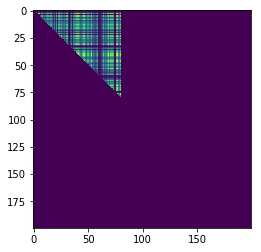

In [10]:
plt.imshow(mergeProbs)
plt.show()